[BPI Challenge 2012](https://www.win.tue.nl/bpi/doku.php?id=2012:challenge)

# Inicialização do ambiente

## Importando bibliotecas

In [ ]:
import numpy as np
import pandas as pd
from google.colab import files
from google_drive_downloader import GoogleDriveDownloader as gdd

## Carregando os dados

In [ ]:
google_id = "1wWxY2N737gjof4FQkTnaBAQaQu8_4g6L"
gdd.download_file_from_google_drive(file_id=google_id, 
                                    dest_path = './data.csv', 
                                    showsize = True)
log = pd.read_csv("data.csv")

21.2 MiB Done.


In [ ]:
log.sample(10)

,Case ID,Activity,AMOUNT_REQ,REG_DATE,org:resource,lifecycle:transition,time:timestamp
169925,199768,W_Valideren aanvraag,38000,10/01/2012 23:50:51,11259.0,SCHEDULE,23/01/2012 11:35:25
102239,189805,W_Nabellen offertes,25000,29/11/2011 12:31:07,11002.0,START,26/01/2012 13:49:44
92061,188146,W_Afhandelen leads,15600,22/11/2011 17:26:18,10228.0,START,22/11/2011 21:06:58
182506,201716,W_Valideren aanvraag,10000,17/01/2012 15:09:14,10809.0,COMPLETE,07/02/2012 09:09:33
237187,209939,A_PARTLYSUBMITTED,5000,15/02/2012 22:09:57,112.0,COMPLETE,15/02/2012 22:10:01
109702,190896,O_CREATED,8000,03/12/2011 10:59:48,11000.0,COMPLETE,03/12/2011 11:13:20
87758,187346,A_SUBMITTED,30000,19/11/2011 13:28:48,112.0,COMPLETE,19/11/2011 13:28:48
64857,183211,W_Nabellen incomplete dossiers,25000,08/11/2011 18:35:47,NaN,START,16/11/2011 14:17:01
32720,178575,W_Nabellen offertes,33000,20/10/2011 14:15:38,10909.0,COMPLETE,27/10/2011 20:49:08
143458,196015,W_Nabellen offertes,15000,28/12/2011 11:08:23,11259.0,COMPLETE,05/01/2012 13:16:53


In [ ]:
log.shape

(262200, 7)

In [ ]:
log['Case ID'].nunique()

13087

In [ ]:
data = log.copy()

# Análise exploratória

In [ ]:
data.shape #quantidade de eventos e quantidade de características descritivas do evento

(262200, 7)

In [ ]:
n_cases = len(data['Case ID'].unique())
n_cases

13087

In [ ]:
data.Activity.value_counts()

W_Completeren aanvraag            54850
W_Nabellen offertes               52016
W_Nabellen incomplete dossiers    25190
W_Valideren aanvraag              20809
W_Afhandelen leads                16566
A_PARTLYSUBMITTED                 13087
A_SUBMITTED                       13087
A_DECLINED                         7635
A_PREACCEPTED                      7367
O_SELECTED                         7030
O_SENT                             7030
O_CREATED                          7030
A_ACCEPTED                         5113
A_FINALIZED                        5015
O_CANCELLED                        3655
O_SENT_BACK                        3454
A_CANCELLED                        2807
A_APPROVED                         2246
A_ACTIVATED                        2246
A_REGISTERED                       2246
O_ACCEPTED                         2243
O_DECLINED                          802
W_Beoordelen fraude                 664
W_Wijzigen contractgegevens          12
Name: Activity, dtype: int64

Renomeação das atividades de alemão para inglês

In [ ]:
data['Activity'] = data['Activity'].replace({
                    'W_Nabellen incomplete dossiers': 'W_Calling to add missing information to the application',
                    'W_Afhandelen leads':'W_Fixing incoming lead',
                    'W_Completeren aanvraag':'W_Filling in information for the application',
                    'W_Nabellen offertes': 'W_Calling after sent offers',
                    'W_Valideren aanvraag': 'W_Assessing the application',
                    'W_Beoordelen fraude': 'W_Evaluate fraud',
                    'W_Wijzigen contractgegevens': 'W_Change contract details'})

In [ ]:
data['org:resource'].value_counts()

112.0      45687
11169.0     7825
10138.0     7690
11181.0     7551
10861.0     7382
           ...  
10124.0       10
11269.0        6
10125.0        6
11254.0        5
10821.0        2
Name: org:resource, Length: 68, dtype: int64

Somente as atividades que começam com "W_" tem informações de recursos, início e fim, então já vou filtrar aqui essas atividades 

In [ ]:
data = data[data['Activity'].apply(lambda x: 'W_' in x)]

Quantidade de casos:

In [ ]:
n_cases = len(data['Case ID'].unique())
n_cases

9658

In [ ]:
data[data['lifecycle:transition'] == 'START'].to_csv('data_logformat.csv', index = False)
files.download('data_logformat.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Verificação das informações sobre recursos

Quantos dos casos nao tem informação de recurso em algum dos eventos?

In [ ]:
len(data[data["org:resource"].isnull()]['Case ID'].unique())

3528

Filtrando só os casos que seus eventos que tem recurso associado...


In [ ]:
missing_resource_cases = data[data["org:resource"].isnull()]['Case ID'].unique()
data = data[~data['Case ID'].isin(missing_resource_cases)]
len(data['Case ID'].unique()) #qtd de casos que sobraram dos 13087 iniciais

6130

Distribuição da quantidade de eventos por recurso:

In [ ]:
data['org:resource'].value_counts()

112.0      6131
11169.0    3209
10861.0    3012
10909.0    2926
10913.0    2871
11119.0    2784
11203.0    2759
11181.0    2715
10982.0    2548
11122.0    2477
10609.0    2449
11180.0    2281
11259.0    2271
10899.0    2262
10138.0    2219
11201.0    2106
11003.0    2064
11049.0    2029
11189.0    1997
10972.0    1879
10932.0    1873
10881.0    1864
10910.0    1861
11121.0    1617
10629.0    1591
11179.0    1589
11009.0    1589
10889.0    1530
11000.0    1518
10929.0    1480
10809.0    1407
10863.0    1329
11289.0    1260
10912.0    1215
11019.0    1158
10933.0    1137
10939.0     850
11302.0     804
11300.0     737
10931.0     677
11299.0     632
11002.0     632
11309.0     586
11319.0     582
10789.0     566
10935.0     547
10188.0     376
10228.0     278
10914.0     170
11001.0      74
10779.0      50
11304.0      41
11339.0      39
11079.0      24
10124.0       9
11254.0       5
11269.0       4
10821.0       2
Name: org:resource, dtype: int64

In [ ]:
data[data['org:resource'] == 112]['lifecycle:transition'].value_counts()

SCHEDULE    6130
COMPLETE       1
Name: lifecycle:transition, dtype: int64

O recurso 112 parece ser um "robô" e só tem a evento de transição "SCHEDULE", então vou excluir todos os eventos que esse é o recurso:

In [ ]:
data = data[data['org:resource'] != 112]

Como vou usar a duração da atividade de custo, só me interessa os eventos de início (START) e conclusão (COMPLETE) da atividade - tirar os eventos 'SCHEDULE':

In [ ]:
data['lifecycle:transition'].value_counts()

COMPLETE    35165
START       34759
SCHEDULE     8637
Name: lifecycle:transition, dtype: int64

In [ ]:
data = data[data['lifecycle:transition']!='SCHEDULE']

In [ ]:
data.to_csv('bpi12_filtered.csv',index=False)
from google.colab import files
#files.download('bpi12_filtered.csv') 

In [ ]:
data['lifecycle:transition'].value_counts()

COMPLETE    35165
START       34759
Name: lifecycle:transition, dtype: int64

Quantos eventos existentes para cada atividade em cada caso?

In [ ]:
(pd.DataFrame(data.groupby(['Case ID','Activity'])['AMOUNT_REQ'].count())
                  .reset_index()
                  .rename(columns={'AMOUNT_REQ':'Count'})
                  .Count.value_counts())

2      5888
4      2493
6      1398
8       879
10      473
12      299
14      209
16      171
18      126
20       87
22       69
24       41
7        40
13       38
28       37
17       36
19       36
11       34
9        33
26       33
23       28
15       27
21       26
27       25
5        22
25       18
29       14
30       13
31       11
42       10
32        9
40        8
3         8
36        7
34        6
44        6
33        5
48        4
1         3
54        3
35        3
37        3
46        3
38        2
52        2
56        2
39        2
66        2
88        1
50        1
60        1
114       1
74        1
70        1
58        1
Name: Count, dtype: int64

In [ ]:
#Interpretação: Em 5888 atividades, há 2 eventos relacionado a ela no case no qual ela acontece

Qual a porcentagem de atividades que acontecem essa quantidade de eventos relacionados a ela?

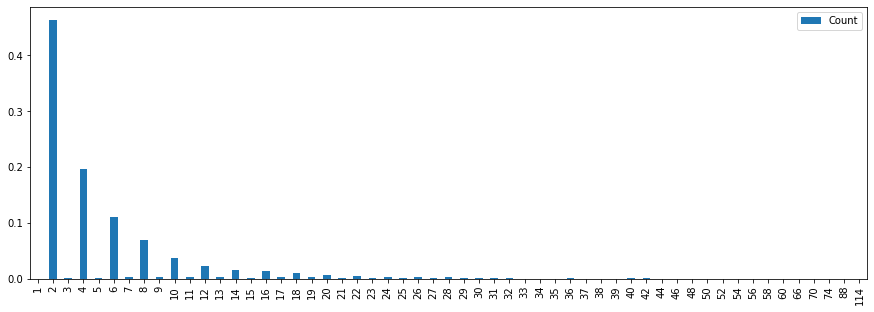

In [ ]:
aux = pd.DataFrame((data.groupby(['Case ID','Activity'])
                       .AMOUNT_REQ.count())
                       .reset_index()
                       .rename(columns={'AMOUNT_REQ':'Count'}))
_ = pd.DataFrame(aux.Count.value_counts().sort_index()/aux.shape[0]).plot(kind='bar', figsize=(15,5))

# Seleção de recursos

Selecionarmos os parte dos recursos, como nos artigos correlatos:

In [ ]:
act_count = pd.DataFrame(data.groupby('org:resource')['Activity'].count().sort_values()).reset_index()
resources2del = act_count[act_count.Activity < act_count.Activity.mean()]['org:resource']
print('#recursos desconsiderados:', len(resources2del))

#recursos desconsiderados: 27


In [ ]:
act_count.Activity.mean()

1226.7368421052631

In [ ]:
data.shape[0]/data['org:resource'].nunique()

1226.7368421052631

In [ ]:

cases2del = data[data['org:resource'].isin(resources2del)]['Case ID'].unique()
print('#casos sem filtrar recursos:', len(data['Case ID'].unique()))
data = data[~data['Case ID'].isin(cases2del)]
print('#casos filtrando recursos:', len(data['Case ID'].unique()))

#casos sem filtrar recursos: 6129
#casos filtrando recursos: 3480


In [ ]:
data['time:timestamp'] = pd.to_datetime(data['time:timestamp'])

In [ ]:
select = data.sort_values('time:timestamp').iloc[[6,7,8,9,80,81,85,86]]
select.Activity = select.Activity.apply(lambda x: x.replace('W_',''))
select.columns = ['Case', 'Task', 'Amount', 'Reg Date', 'Resource', 'Lifecycle', 'Timestamp']
select[['Case', 'Task', 'Amount', 'Resource', 'Lifecycle', 'Timestamp']]

,Case,Task,Amount,Resource,Lifecycle,Timestamp
50521,181181,Filling in information for the application,8000,11189.0,START,2011-01-11 09:34:02
50522,181181,Filling in information for the application,8000,11189.0,COMPLETE,2011-01-11 09:36:48
50574,181199,Fixing incoming lead,25000,11121.0,START,2011-01-11 09:45:37
50577,181199,Fixing incoming lead,25000,11121.0,COMPLETE,2011-01-11 10:06:00
51223,181279,Fixing incoming lead,500,10889.0,START,2011-01-11 14:26:38
51021,181249,Filling in information for the application,5000,11189.0,START,2011-01-11 14:26:45
51022,181249,Filling in information for the application,5000,11189.0,COMPLETE,2011-01-11 14:28:35
51225,181279,Fixing incoming lead,500,10889.0,COMPLETE,2011-01-11 14:28:47


# Cálculo da duração das atividades (custo no MDP)

In [ ]:
data['time:timestamp'] = pd.to_datetime(data['time:timestamp'], format="%d/%m/%Y %H:%M:%S")

In [ ]:
data = data.sort_values(['Case ID','Activity','org:resource','time:timestamp'])
data.head()

,Case ID,Activity,AMOUNT_REQ,REG_DATE,org:resource,lifecycle:transition,time:timestamp
775,173781,W_Filling in information for the application,1500,01/10/2011 18:10:34,11180.0,START,2011-03-10 09:14:50
777,173781,W_Filling in information for the application,1500,01/10/2011 18:10:34,11180.0,COMPLETE,2011-03-10 09:25:12
1013,173799,W_Filling in information for the application,10000,01/10/2011 20:27:34,10982.0,START,2011-04-10 18:15:29
1014,173799,W_Filling in information for the application,10000,01/10/2011 20:27:34,10982.0,COMPLETE,2011-04-10 18:15:39
1011,173799,W_Filling in information for the application,10000,01/10/2011 20:27:34,11121.0,START,2011-04-10 18:13:53


In [ ]:
def calc_duration(x):
  if (x['lifecycle:transition'] == 'COMPLETE' and 
      x['lifecycle:transition_shifted'] == 'START' and 
      x['Activity_shifted'] == x['Activity'] and
      x['org:resource_shifted'] == x['org:resource']):
    return x['time:timestamp'] - x['time:timestamp_shifted']
  return np.nan

In [ ]:
data['lifecycle:transition_shifted'] = data['lifecycle:transition'].shift()
data['Activity_shifted'] = data['Activity'].shift()
data['org:resource_shifted'] = data['org:resource'].shift()
data['time:timestamp_shifted'] = data['time:timestamp'].shift()
data['duration'] = data.apply(calc_duration, axis=1)
data['Duration(s)'] = data.duration.apply(lambda x: pd.Timedelta(x).total_seconds())

# Divisão treinamento e teste

In [ ]:
data.shape

(24333, 13)

In [ ]:
data['time:timestamp'].min()

Timestamp('2011-01-11 09:01:43')

In [ ]:
data['time:timestamp'].max()

Timestamp('2012-12-03 17:25:50')

In [ ]:
import plotly.express as px
px.box(data, y = 'time:timestamp')

In [ ]:
division_point = data['time:timestamp'].quantile(0.75)
data_train = data[data['time:timestamp'] < division_point]
data_test = data[data['time:timestamp'] >= division_point]

In [ ]:
division_point

Timestamp('2012-02-18 14:05:41')

In [ ]:
data_train.shape #quantidade de eventos no conjunto de treinamento

(18249, 13)

In [ ]:
data_test.shape #quantidade de eventos no conjunto de teste

(6084, 13)

In [ ]:
len(data_train['Case ID'].unique()) #quantidade de casos no conjunto de treinamento

2895

In [ ]:
len(data_test['Case ID'].unique()) #quantidade de casos no conjunto de teste

1079

In [ ]:
len(data['Case ID'].unique()) #quantidade de casos no conjunto completo
# PS: diferente da soma dos casos no conj de treinamento e no conjunto de testes, 
# pois um caso pode ter alguns eventos no treinamento e alguns no teste

3480

# Criar resources' workload

In [ ]:
qtd_resources = len(data_train['org:resource'].unique())
qtd_resources

30

In [ ]:
data_train['Workload_count'] = [{int(resource): 0 for resource in data_train['org:resource'].unique()}]*len(data_train)
data_train.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Case ID,Activity,AMOUNT_REQ,REG_DATE,org:resource,lifecycle:transition,time:timestamp,lifecycle:transition_shifted,Activity_shifted,org:resource_shifted,time:timestamp_shifted,duration,Duration(s),Workload_count
775,173781,W_Filling in information for the application,1500,01/10/2011 18:10:34,11180.0,START,2011-03-10 09:14:50,NaN,NaN,NaN,NaT,NaT,NaN,"{11180: 0, 10982: 0, 11121: 0, 10609: 0, 10899..."
777,173781,W_Filling in information for the application,1500,01/10/2011 18:10:34,11180.0,COMPLETE,2011-03-10 09:25:12,START,W_Filling in information for the application,11180.0,2011-03-10 09:14:50,0 days 00:10:22,622.0,"{11180: 0, 10982: 0, 11121: 0, 10609: 0, 10899..."
1013,173799,W_Filling in information for the application,10000,01/10/2011 20:27:34,10982.0,START,2011-04-10 18:15:29,COMPLETE,W_Filling in information for the application,11180.0,2011-03-10 09:25:12,NaT,NaN,"{11180: 0, 10982: 0, 11121: 0, 10609: 0, 10899..."


In [ ]:
RESOURCES_WORKLOAD = {int(resource): 0 for resource in data_train['org:resource'].unique()}
def update_workload_count(x):
  if x['lifecycle:transition'] == 'START': 
    RESOURCES_WORKLOAD[int(x['org:resource'])] += 1
  elif x['lifecycle:transition'] == 'COMPLETE' and RESOURCES_WORKLOAD[int(x['org:resource'])] > 0:
    RESOURCES_WORKLOAD[int(x['org:resource'])] -= 1
  x.Workload_count = RESOURCES_WORKLOAD.copy()
  return x

In [ ]:
data_train = data_train.sort_values(by='time:timestamp').apply(lambda x: update_workload_count(x), axis=1)

In [ ]:
RESOURCES_WORKLOAD

{10138: 0,
 10609: 0,
 10629: 0,
 10809: 0,
 10861: 0,
 10881: 0,
 10889: 0,
 10899: 0,
 10909: 1,
 10910: 1,
 10913: 0,
 10929: 0,
 10932: 0,
 10972: 1,
 10982: 0,
 11000: 0,
 11003: 0,
 11009: 0,
 11049: 0,
 11119: 0,
 11121: 0,
 11122: 0,
 11169: 0,
 11179: 0,
 11180: 0,
 11181: 0,
 11189: 0,
 11201: 0,
 11203: 0,
 11259: 0}

In [ ]:
def def_workload_status(x):
  activities_being_exec = np.array(list(x['Workload_count'].values())).sum()
  AVG_R = (activities_being_exec/qtd_resources) 
  def get_r_workload(resource):
    if x['Workload_count'][resource] < 1:
      return 'FREE'
    elif x['Workload_count'][resource] <= AVG_R: 
      return 'LOW'
    return 'HIGH' 
  x['Workload'] = {resource: get_r_workload(resource) for resource in x['Workload_count']}
  return x
data_train = data_train.apply(lambda x: def_workload_status(x), axis=1)
#nesse cj de dados, acaba sendo sempre 'FREE' ou 'HIGH' porque são poucas atividades executadas 
#num mesmo intervalo de tempo -> fica bem pequena a média de atividades em cada r, como a maioria
#executa 0 atividades - activities_being_exec é pequeno e qtd_resources é grande (30).

Excluindo as atividades de início (START) e as que não tem evento de início (já que a duration delas vai estar vazio)

In [ ]:
data_train.shape

(18249, 15)

In [ ]:
data_train = data_train.dropna()
data_train.shape

(9086, 15)

In [ ]:
data_train_final = data_train[['Case ID', 'Activity', 'org:resource', 'Workload', 'Duration(s)']]
data_train_final['org:resource'] = data_train_final['org:resource'].astype(int).astype(str)
data_train_final = data_train_final.rename(columns = {'org:resource':'Resource'})
data_train_final

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Case ID,Activity,Resource,Workload,Duration(s)
50520,181181,W_Filling in information for the application,11189,"{11180: 'FREE', 10982: 'FREE', 11121: 'FREE', ...",13.0
45574,180445,W_Calling after sent offers,11189,"{11180: 'FREE', 10982: 'FREE', 11121: 'FREE', ...",66.0
50686,181219,W_Fixing incoming lead,11169,"{11180: 'FREE', 10982: 'FREE', 11121: 'FREE', ...",29.0
50522,181181,W_Filling in information for the application,11189,"{11180: 'FREE', 10982: 'FREE', 11121: 'FREE', ...",166.0
50577,181199,W_Fixing incoming lead,11121,"{11180: 'FREE', 10982: 'FREE', 11121: 'FREE', ...",1223.0
...,...,...,...,...,...
240059,210476,W_Filling in information for the application,10909,"{11180: 'FREE', 10982: 'FREE', 11121: 'FREE', ...",388.0
240061,210476,W_Calling after sent offers,10909,"{11180: 'FREE', 10982: 'FREE', 11121: 'FREE', ...",172.0
240328,210521,W_Filling in information for the application,10909,"{11180: 'FREE', 10982: 'FREE', 11121: 'FREE', ...",83.0
217957,206790,W_Calling to add missing information to the ap...,10889,"{11180: 'FREE', 10982: 'FREE', 11121: 'FREE', ...",613.0


Uma visualização rápida da duração das atividades por recurso:

In [ ]:
df2plot = data_train_final.groupby(['Resource','Activity'])['Duration(s)'].mean().reset_index()
df2plot['Resource'] = "r_" + df2plot['Resource'].astype(int).astype(str)

In [ ]:
import plotly.express as px
px.bar(df2plot, x='Resource', y = 'Duration(s)', color = 'Activity', barmode = 'group', 
       template='plotly_white', width = 1200, height = 400).show()

In [ ]:
data_test['Workload_count'] = [{int(resource): 0 for resource in data_test['org:resource'].unique()}]*len(data_test)
RESOURCES_WORKLOAD = {int(resource): 0 for resource in data_test['org:resource'].unique()}
data_test_wl = data_test.sort_values(by='time:timestamp').apply(lambda x: update_workload_count(x), axis=1)
data_test_wl = data_test_wl.apply(lambda x: def_workload_status(x), axis=1)
data_test_wl = data_test_wl.dropna()
data_test_wl = data_test_wl[['Case ID', 'Activity', 'org:resource', 'Workload', 'Workload_count', 'Duration(s)', 'lifecycle:transition']]
data_test_wl['org:resource'] = data_test_wl['org:resource'].astype(int).astype(str)
data_test_wl = data_test_wl.rename(columns = {'org:resource':'Resource'})
data_test_wl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Case ID,Activity,Resource,Workload,Workload_count,Duration(s),lifecycle:transition
190060,202899,W_Calling after sent offers,10909,"{10881: 'FREE', 10809: 'FREE', 10972: 'FREE', ...","{10881: 0, 10809: 0, 10972: 0, 10909: 0, 11189...",10.0,COMPLETE
210172,205754,W_Calling after sent offers,10909,"{10881: 'FREE', 10809: 'FREE', 10972: 'FREE', ...","{10881: 0, 10809: 0, 10972: 0, 10909: 0, 11189...",135.0,COMPLETE
240984,210629,W_Filling in information for the application,11203,"{10881: 'FREE', 10809: 'FREE', 10972: 'FREE', ...","{10881: 0, 10809: 0, 10972: 0, 10909: 0, 11189...",923.0,COMPLETE
208298,205514,W_Calling after sent offers,10909,"{10881: 'FREE', 10809: 'FREE', 10972: 'FREE', ...","{10881: 0, 10809: 0, 10972: 0, 10909: 0, 11189...",290.0,COMPLETE
189159,202755,W_Calling after sent offers,10909,"{10881: 'FREE', 10809: 'FREE', 10972: 'FREE', ...","{10881: 0, 10809: 0, 10972: 0, 10909: 0, 11189...",103.0,COMPLETE
...,...,...,...,...,...,...,...
257999,213609,W_Calling to add missing information to the ap...,10899,"{10881: 'FREE', 10809: 'FREE', 10972: 'HIGH', ...","{10881: 0, 10809: 0, 10972: 1, 10909: 0, 11189...",76.0,COMPLETE
256012,213258,W_Calling to add missing information to the ap...,10899,"{10881: 'FREE', 10809: 'FREE', 10972: 'HIGH', ...","{10881: 0, 10809: 0, 10972: 1, 10909: 0, 11189...",31.0,COMPLETE
260557,214040,W_Assessing the application,10972,"{10881: 'FREE', 10809: 'FREE', 10972: 'HIGH', ...","{10881: 0, 10809: 0, 10972: 1, 10909: 0, 11189...",15.0,COMPLETE
260563,214040,W_Assessing the application,10972,"{10881: 'FREE', 10809: 'FREE', 10972: 'HIGH', ...","{10881: 0, 10809: 0, 10972: 1, 10909: 0, 11189...",427.0,COMPLETE


In [ ]:
df2plot_test = data_test_wl.groupby(['Resource','Activity'])['Duration(s)'].mean().reset_index()
df2plot_test['Resource'] = "r_" + df2plot_test['Resource'].astype(int).astype(str)
px.bar(df2plot_test, x='Resource', y = 'Duration(s)', color = 'Activity', barmode = 'group', 
       template='plotly_white', width = 1200, height = 400).show()

# Salvar conjuntos de dados finais

In [ ]:
data_train_final.to_csv('bpi12_preprocessed_train.csv',index=False)
files.download('bpi12_preprocessed_train.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
data_train_final.shape

(9086, 5)

In [ ]:
data_test.to_csv('bpi12_preprocessed_test.csv',index=False)
files.download('bpi12_preprocessed_test.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
data_test[data['lifecycle:transition'] == 'START'].shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



(3014, 14)

# Definir função de custo 

In [ ]:
import pickle
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge 
from sklearn.neural_network import MLPRegressor 
# um pouco melhor que os demais, mas acho que a complexidade a mais nao vale a pena
# testei Ridge, Lasso, ElasticNet, BayesianRidge, RandomForestRegressor - todos similares ou piores
from sklearn.metrics import r2_score

In [ ]:
def get_resource_workload_int(x):
  x['Workload-esp_resource'] = int(x['Workload'][x['org:resource']].replace('FREE','0').replace('LOW','1').replace('HIGH','2'))
  return x

data_train = data_train.apply(get_resource_workload_int, axis=1)

In [ ]:
x = pd.DataFrame()
x['workload'] = data_train['Workload-esp_resource'] #workload do rec. (convert. p/ escala numérica)
activities_dummies = pd.get_dummies(data_train['Activity']) 
x = x.join(activities_dummies) # dummies para identificar a atividade
resources_dummies = pd.get_dummies(data_train['org:resource'])
x = x.join(resources_dummies) # dummies para identificar o recurso
print('#linhas (datapoints), #colunas (features):', x.shape)
y = data_train['Duration(s)']

#linhas (datapoints), #colunas (features): (9086, 37)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model = LinearRegression().fit(x_train, y_train)
y_pred = model.predict(x_test)
r2_score(y_test, y_pred)

-0.0342730493555381

In [ ]:
pickle.dump(model, open('duration_predictor.pickle','wb'))
pickle.dump(x.columns, open('duration_predictor_features.pickle','wb'))
from google.colab import files
files.download('duration_predictor.pickle')
files.download('duration_predictor_features.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pond_mean = data_train.groupby(['org:resource','Activity','Workload-esp_resource'])['Duration(s)'].agg(['mean','count','std'])
pond_mean.to_csv('duration_predictor_mean.csv')
from google.colab import files
files.download('duration_predictor_mean.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Avaliar relação custo x workload

In [ ]:
data_train.head()

,Case ID,Activity,AMOUNT_REQ,REG_DATE,org:resource,lifecycle:transition,time:timestamp,lifecycle:transition_shifted,Activity_shifted,org:resource_shifted,time:timestamp_shifted,duration,Duration(s),Workload_count,Workload,Workload-esp_resource
777,173781,W_Filling in information for the application,1500,01/10/2011 18:10:34,11180.0,COMPLETE,2011-10-03 09:25:12,START,W_Filling in information for the application,11180.0,2011-10-03 09:14:50,0 days 00:10:22,622.0,"{11180: 0, 11119: 0, 10982: 0, 11169: 0, 11122...","{11180: 'FREE', 11119: 'FREE', 10982: 'FREE', ...",0
2094,173982,W_Filling in information for the application,8000,03/10/2011 09:30:51,11180.0,COMPLETE,2011-10-03 12:32:27,START,W_Filling in information for the application,11180.0,2011-10-03 12:28:33,0 days 00:03:54,234.0,"{11180: 0, 11119: 0, 10982: 0, 11169: 0, 11122...","{11180: 'FREE', 11119: 'FREE', 10982: 'FREE', ...",0
2102,173982,W_Filling in information for the application,8000,03/10/2011 09:30:51,11180.0,COMPLETE,2011-10-03 12:36:34,START,W_Filling in information for the application,11180.0,2011-10-03 12:32:33,0 days 00:04:01,241.0,"{11180: 0, 11119: 0, 10982: 0, 11169: 0, 11122...","{11180: 'FREE', 11119: 'FREE', 10982: 'FREE', ...",0
3591,174162,W_Fixing incoming lead,4000,03/10/2011 18:07:45,11119.0,COMPLETE,2011-10-03 18:19:01,START,W_Fixing incoming lead,11119.0,2011-10-03 18:16:37,0 days 00:02:24,144.0,"{11180: 0, 11119: 0, 10982: 0, 11169: 0, 11122...","{11180: 'FREE', 11119: 'FREE', 10982: 'FREE', ...",0
3709,174186,W_Fixing incoming lead,15000,03/10/2011 19:17:45,10982.0,COMPLETE,2011-10-03 19:41:01,START,W_Fixing incoming lead,10982.0,2011-10-03 19:39:24,0 days 00:01:37,97.0,"{11180: 0, 11119: 0, 10982: 0, 11169: 0, 11122...","{11180: 'FREE', 11119: 'FREE', 10982: 'FREE', ...",0


In [ ]:
data_train['lifecycle:transition'].value_counts()

COMPLETE    9015
Name: lifecycle:transition, dtype: int64

In [ ]:
def get_res_wl(x):
  x['Resource Workload (count)'] = x['Workload_count'][int(x['org:resource'])]
  x['Resource Workload'] = x['Workload'][int(x['org:resource'])]
  return x

data_train_reswl = data_train.apply(get_res_wl, axis=1)

In [ ]:
grouped = pd.DataFrame(data_train_reswl.reset_index()
                             .groupby(['org:resource','Resource Workload'])['index']
                             .count())
grouped = (grouped.reset_index()
                 .rename(columns = {'org:resource':'Resource', 'index':'Count'})
                 .sort_values(['Resource Workload','Count']))

In [ ]:
fig = px.bar(grouped, x = 'Resource', y = 'Count', color = 'Resource Workload', barmode = 'group',
       template = 'plotly_white')
fig.update_xaxes(type='category')
fig

In [ ]:
total_per_resource = grouped.groupby('Resource').agg({'Count': 'sum'}).rename(columns={'Count':'Sum'})
grouped_relative = total_per_resource.join(grouped.set_index('Resource')).reset_index()
grouped_relative['Relative rate'] = grouped_relative.apply(lambda x: x.Count/x.Sum, axis=1)
grouped_relative

,Resource,Sum,Resource Workload,Count,Relative rate
0,10138.0,275,FREE,274,0.996364
1,10138.0,275,HIGH,1,0.003636
2,10609.0,243,FREE,239,0.983539
3,10609.0,243,HIGH,4,0.016461
4,10629.0,253,FREE,245,0.968379
5,10629.0,253,HIGH,8,0.031621
6,10809.0,170,FREE,170,1.000000
7,10861.0,384,FREE,341,0.888021
8,10861.0,384,HIGH,43,0.111979
9,10881.0,225,FREE,200,0.888889


In [ ]:
fig = px.bar(grouped_relative.sort_values('Resource').round(2), x = 'Resource', y = 'Relative rate', 
             text = 'Relative rate', color = 'Resource Workload', template = 'plotly_white', height = 400)
fig.update_xaxes(type='category', tickangle=45)
fig

In [ ]:
def get_res_wl_test(x):
  x['Resource Workload (count)'] = x['Workload_count'][int(x['Resource'])]
  x['Resource Workload'] = x['Workload'][int(x['Resource'])]
  return x

data_test_reswl = data_test_wl.apply(get_res_wl_test, axis=1)
grouped_test = pd.DataFrame(data_test_reswl.reset_index()
                             .groupby(['Resource','Resource Workload'])['index']
                             .count())
grouped_test = (grouped_test.reset_index()
                 .rename(columns = {'index':'Count'})
                 .sort_values(['Resource Workload','Count']))

total_per_resource_test = grouped_test.groupby('Resource').agg({'Count': 'sum'}).rename(columns={'Count':'Sum'})
grouped_relative_test = total_per_resource_test.join(grouped_test.set_index('Resource')).reset_index()
grouped_relative_test['Count relative'] = grouped_relative_test.apply(lambda x: x.Count/x.Sum, axis=1)

In [ ]:
fig = px.bar(grouped_relative_test.sort_values('Resource').round(2), x = 'Resource', y = 'Count relative', 
             color = 'Resource Workload', text = 'Count relative', template = 'plotly_white', height = 400)
fig.update_xaxes(type='category', tickangle=45)
fig

In [ ]:
px.box(data_test_reswl, y = 'Duration(s)', color = 'Resource Workload', width = 400, height = 600, template = 'plotly_white')

In [ ]:
count_workloads = pd.DataFrame(grouped.groupby('Resource')['Resource Workload'].count())
count_workloads['Both Workloads?'] = count_workloads['Resource Workload'] == 2
count_workloads['Both Workloads?'].sum()/30

0.7666666666666667

In [ ]:
count_workloads['Both Workloads?'].sum()

23

In [ ]:
data_train_reswl.head()

,Case ID,Activity,AMOUNT_REQ,REG_DATE,org:resource,lifecycle:transition,time:timestamp,lifecycle:transition_shifted,Activity_shifted,org:resource_shifted,time:timestamp_shifted,duration,Duration(s),Workload_count,Workload,Workload-esp_resource,Resource Workload (count),Resource Workload
2054,173961,W_Fixing incoming lead,25000,02/10/2011 23:19:50,10889.0,COMPLETE,2011-10-03 09:23:39,START,W_Fixing incoming lead,10889.0,2011-10-03 09:18:53,0 days 00:04:46,286.0,"{11180: 1, 10982: 0, 11121: 0, 10609: 0, 10899...","{11180: 'HIGH', 10982: 'FREE', 11121: 'FREE', ...",0,0,FREE
777,173781,W_Filling in information for the application,1500,01/10/2011 18:10:34,11180.0,COMPLETE,2011-10-03 09:25:12,START,W_Filling in information for the application,11180.0,2011-10-03 09:14:50,0 days 00:10:22,622.0,"{11180: 0, 10982: 0, 11121: 0, 10609: 0, 10899...","{11180: 'FREE', 10982: 'FREE', 11121: 'FREE', ...",0,0,FREE
1739,173934,W_Fixing incoming lead,15000,02/10/2011 20:05:03,10889.0,COMPLETE,2011-10-03 09:29:09,START,W_Fixing incoming lead,10889.0,2011-10-03 09:24:04,0 days 00:05:05,305.0,"{11180: 0, 10982: 0, 11121: 0, 10609: 0, 10899...","{11180: 'FREE', 10982: 'FREE', 11121: 'FREE', ...",0,0,FREE
1532,173901,W_Fixing incoming lead,5750,02/10/2011 16:12:08,10889.0,COMPLETE,2011-10-03 09:33:46,START,W_Fixing incoming lead,10889.0,2011-10-03 09:30:52,0 days 00:02:54,174.0,"{11180: 1, 10982: 0, 11121: 0, 10609: 0, 10899...","{11180: 'HIGH', 10982: 'FREE', 11121: 'FREE', ...",2,1,HIGH
1538,173904,W_Fixing incoming lead,5000,02/10/2011 16:52:36,10889.0,COMPLETE,2011-10-03 09:35:23,START,W_Fixing incoming lead,10889.0,2011-10-03 09:29:32,0 days 00:05:51,351.0,"{11180: 1, 10982: 0, 11121: 0, 10609: 0, 10899...","{11180: 'HIGH', 10982: 'FREE', 11121: 'FREE', ...",0,0,FREE


In [ ]:
#data_train_reswl['org:resource'] = data_train_reswl['org:resource'].astype(str)

px.scatter(data_train_reswl, x='Resource Workload (count)', y='Duration(s)', color='org:resource', facet_row='Activity', 
           trendline = 'ols', height = 1200)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
px.line(data_train_reswl.groupby(['org:resource', 'Activity', 'Resource Workload'])['Duration(s)'].mean().reset_index(),
        x = 'Resource Workload', y = 'Duration(s)', color = 'org:resource', facet_row = 'Activity', height = 2000)

In [ ]:
px.line(data_train_reswl.groupby(['org:resource', 'Resource Workload'])['Duration(s)'].mean().reset_index(),
        x = 'Resource Workload', y = 'Duration(s)', color = 'org:resource')

In [ ]:
px.line(data_train_reswl.groupby('Resource Workload')['Duration(s)'].mean().reset_index(),
        x = 'Resource Workload', y = 'Duration(s)')

In [ ]:
px.histogram(data_train_reswl, x = 'Duration(s)', color = 'Resource Workload', nbins=10000, barmode='group')

In [ ]:
px.histogram(data_train_reswl, x = 'Duration(s)', color = 'Resource Workload', nbins=10000, barmode='group', histnorm='percent')

In [ ]:
px.histogram(data_train_reswl, x = 'Duration(s)', color = 'Resource Workload', nbins=10000, barmode='group',
             facet_row = 'Activity', height = 2000)

In [ ]:
px.histogram(data_train_reswl, x = 'Duration(s)', color = 'Resource Workload', nbins=10000, barmode='group', histnorm='percent',
             facet_row = 'Activity', height = 2000)

In [ ]:
import plotly.figure_factory as ff
ff.create_distplot([sorted(list(data_train_reswl[data_train_reswl['Resource Workload'] == 'FREE']['Duration(s)'])), 
                    sorted(list(data_train_reswl[data_train_reswl['Resource Workload'] == 'HIGH']['Duration(s)']))], 
                   ['FREE', 'HIGH'], bin_size = 60)

In [ ]:
px.box(data_train_reswl, y = 'Duration(s)', color = 'Resource Workload', width = 400, height = 600, template = 'plotly_white')

In [ ]:
px.scatter(data_train_reswl, x = 'Activity', y = 'Duration(s)', color = 'Resource Workload')

In [ ]:
px.box(data_train_reswl, x = 'Activity', y = 'Duration(s)', color = 'Resource Workload')

In [ ]:
data_train_reswl_grouped = (data_train_reswl.groupby(['org:resource', 'Activity', 'Resource Workload'])['Duration(s)']
                                            .mean().reset_index().sort_values(['Activity', 'org:resource', 'Resource Workload']))
data_train_reswl_grouped['Prev Resource'] = data_train_reswl_grouped['org:resource'].shift()
data_train_reswl_grouped['Prev Activity'] = data_train_reswl_grouped['Activity'].shift()
data_train_reswl_grouped['Prev Resource Workload'] = data_train_reswl_grouped['Resource Workload'].shift()
data_train_reswl_grouped['Prev Duration'] = data_train_reswl_grouped['Duration(s)'].shift()

def calc_inclin(x):
  if (x['Resource Workload'] == 'HIGH' and 
      x['org:resource'] == x['Prev Resource'] and 
      x['Activity'] == x['Prev Activity'] and 
      x['Prev Resource Workload'] == 'FREE'):
  
    x['Inclin'] = x['Duration(s)'] - x['Prev Duration'] 
    #SE POSITIVO, A INCLINACAO A RELACAO É POSITIVA, OU SEJA, SE AUMENTA O WORKLOAD (DE FREE, QUE É O ANT, PRA HIGH), AUMENTA A DURACAO

  return x

data_train_reswl_grouped = data_train_reswl_grouped.apply(calc_inclin, axis=1)

In [ ]:
len(data_train['org:resource'].unique()) * len(data_train['Activity'].unique()) * 2 
#quero ter exemplos com HIGH e com FREE pra todos os recursos pra todas as atividades

360

In [ ]:
data_train_reswl_grouped.shape

(200, 9)

In [ ]:
data_train_reswl_grouped.Inclin.isnull().sum()

136

In [ ]:
count_act_res = pd.DataFrame(data_train_reswl_grouped
                              .groupby(['org:resource','Activity'])['Resource Workload']
                              .count()).reset_index()
count_act_res['Both Workloads?'] = count_act_res['Resource Workload'] == 2
(count_act_res.groupby(['org:resource','Activity'])['Both Workloads?'].sum()>0).sum()

64

In [ ]:
count_act_res['Only 1'] = count_act_res['Resource Workload'] < 2
(count_act_res.groupby(['org:resource','Activity'])['Only 1'].sum()>0).sum()

72

In [ ]:
(~data_train_reswl_grouped.Inclin.isnull()).sum()

64

In [ ]:
data_train_reswl_grouped[data_train_reswl_grouped.Inclin>0].shape[0]

24

In [ ]:
data_train_reswl_grouped[data_train_reswl_grouped.Inclin<0].shape[0]

40

In [ ]:
# quantidade de recursos que tem exemplos com 'FREE' e com 'HIGH'
len(data_train_reswl_grouped[~data_train_reswl_grouped.Inclin.isnull()]['org:resource'].unique())

23

In [ ]:
# quantidade de atividades para as quais cada um desses recursos tem exemplos tanto com 'FREE' e quanto com 'HIGH'
data_train_reswl_grouped[~data_train_reswl_grouped.Inclin.isnull()].groupby('org:resource').Activity.count()

org:resource
10629.0    2
10861.0    4
10881.0    2
10889.0    3
10899.0    1
10909.0    3
10910.0    4
10913.0    3
10929.0    2
10932.0    4
10982.0    2
11000.0    4
11003.0    4
11009.0    2
11119.0    2
11121.0    4
11169.0    4
11179.0    3
11180.0    1
11189.0    4
11201.0    2
11203.0    3
11259.0    1
Name: Activity, dtype: int64

In [ ]:
# média da quantidade de atividades para as quais cada um desses recursos tem exemplos com 'FREE' e com 'HIGH'
data_train_reswl_grouped[~data_train_reswl_grouped.Inclin.isnull()].groupby('org:resource').Activity.count().mean()

2.782608695652174

In [ ]:
# quantos dos 23 recursos tem (em média) crescimento quando a ocupacao vai de FREE pra HIGH
aux = data_train_reswl_grouped.groupby('org:resource').Inclin.mean().reset_index()
aux = aux[aux['Inclin']>0]
len(aux['org:resource'].unique())

8

In [ ]:
# quantos dos 23 recursos tem (em média) decaimento quando a ocupacao vai de FREE pra HIGH
aux = data_train_reswl_grouped.groupby('org:resource').Inclin.mean().reset_index()
aux = aux[aux['Inclin']<0]
len(aux['org:resource'].unique())

15